In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Input, Dropout, BatchNormalization, Conv1D, MaxPooling1D, Flatten
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, accuracy_score, mean_squared_error, confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score

# 1 - Load dataset
For now I'll work with 3 second samples. Later might try with 5sec samples

In [3]:
features_3_sec = pd.read_csv('./Data/features_3_sec.csv')
#features_30_sec = pd.read_csv('./Data/features_30_sec.csv')
features_3_sec.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [210]:
features_3_sec.describe()

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
count,9990.0,9990.000000,9990.000000,9990.000000,9.990000e+03,9990.000000,9.990000e+03,9990.000000,9.990000e+03,9990.000000,...,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000
mean,66149.0,0.379534,0.084876,0.130859,2.676388e-03,2199.219431,4.166727e+05,2241.385959,1.182711e+05,4566.076592,...,1.448240,49.988755,-4.198706,51.962753,0.739943,52.488851,-2.497306,54.973829,-0.917584,57.322614
std,0.0,0.090466,0.009637,0.068545,3.585628e-03,751.860611,4.349644e+05,543.854449,1.013505e+05,1642.065335,...,5.735149,34.442816,5.677379,36.400669,5.181313,38.177120,5.111799,41.585677,5.253243,46.444212
min,66149.0,0.107108,0.015345,0.000953,4.379535e-08,472.741636,8.118813e+02,499.162910,1.183520e+03,658.336276,...,-26.850016,1.325786,-27.809795,1.624544,-20.733809,3.437439,-27.448456,3.065302,-35.640659,0.282131
25%,66149.0,0.315698,0.079833,0.083782,6.145900e-04,1630.680158,1.231961e+05,1887.455790,4.876553e+04,3378.311110,...,-2.227478,29.584894,-7.951722,29.863448,-2.516638,29.636197,-5.734123,30.496412,-4.004475,30.011365
50%,66149.0,0.384741,0.085108,0.121253,1.491318e-03,2208.628236,2.650692e+05,2230.575595,8.996072e+04,4631.377892,...,1.461623,41.702393,-4.443021,42.393583,0.733772,41.831377,-2.702366,43.435253,-1.030939,44.332155
75%,66149.0,0.442443,0.091092,0.176328,3.130862e-03,2712.581884,5.624152e+05,2588.340505,1.585674e+05,5591.634521,...,5.149752,59.274619,-0.726945,61.676964,3.888734,62.033906,0.514246,65.328602,2.216603,68.210421
max,66149.0,0.749481,0.120964,0.442567,3.261522e-02,5432.534406,4.794119e+06,3708.147554,1.235143e+06,9487.446477,...,39.144405,683.932556,34.048843,529.363342,36.970322,629.729797,31.365425,1143.230591,34.212101,910.473206


In [211]:
features_3_sec.columns

Index(['filename', 'length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean',
       'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo',
       'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean',
       'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var',
       'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean',
       'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var',
       'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean',
       'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var',
       'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean',
       'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var',
  

In [212]:
labels = features_3_sec.label.unique()
labels

array(['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
       'metal', 'pop', 'reggae', 'rock'], dtype=object)

# 2 - Analyse numerical data
First lets split and prepare the dataset. First, the filenames will be saved in a seperate variable since they're only used for the identification of the entries and not useful for the prediction of each genre. The length column will be dropped, since it is the same in every entry of the dataset, which makes it useless for the task. Finally, the label column will be seperated from the rest of the dataset, since it is the target classification, and encoded using the LabelEncoder.<br/><br/>
Note: For now I won't be worrying with handling the outliers in the data. I might look into it if the results of the models are bad.

In [4]:
filenames = features_3_sec.filename
X = features_3_sec.drop(columns=['filename', 'length', 'label'])
y = features_3_sec.label

encoder = LabelEncoder()
y = encoder.fit_transform(y)

## 2.1 - Numerical data scaling
The data will be scaled using the StandardScaler because of usually giving better results the the MinMax, for example.

In [109]:
X.head()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,-0.487808,0.640520,-0.006624,0.235568,-0.566828,-0.572791,-0.493983,-0.009229,-0.518590,-0.367952,...,-0.750122,-0.299108,0.168647,-0.425137,-0.003423,-0.376938,-0.499464,-0.513562,0.128414,-0.291781
1,-0.403142,0.131835,-0.264944,-0.342134,-0.508798,-0.749862,-0.425382,-0.519010,-0.424118,-0.642268,...,0.457983,0.428544,-0.327031,-0.310040,-0.112125,-0.032083,-0.066593,1.011384,1.275780,0.056425
2,-0.361694,0.764491,0.016695,0.542195,-0.546245,-0.701852,-0.288365,-0.425734,-0.346190,-0.562723,...,0.585548,0.503695,0.428053,-0.648762,0.316311,-0.177372,0.109337,-0.046244,0.653907,-0.521458
3,-0.175714,0.205477,0.024885,-0.063820,-0.723482,-0.700599,-0.517344,-0.348881,-0.607665,-0.474804,...,-0.489524,-0.065309,0.062981,-0.649076,0.092384,-0.464121,-0.211882,-0.099501,0.865880,-0.544744
4,-0.485895,0.337521,0.181345,-0.272072,-0.756246,-0.774827,-0.538557,-0.572962,-0.667537,-0.683920,...,0.112417,-0.570609,0.856651,-0.167089,0.183265,-0.029476,-0.175130,-0.678995,0.276899,-0.606692


In [5]:
scaler = StandardScaler()
X = pd.DataFrame(data=scaler.fit_transform(X), columns=X.columns)
X.head()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,-0.487808,0.640520,-0.006624,0.235568,-0.566828,-0.572791,-0.493983,-0.009229,-0.518590,-0.367952,...,-0.750122,-0.299108,0.168647,-0.425137,-0.003423,-0.376938,-0.499464,-0.513562,0.128414,-0.291781
1,-0.403142,0.131835,-0.264944,-0.342134,-0.508798,-0.749862,-0.425382,-0.519010,-0.424118,-0.642268,...,0.457983,0.428544,-0.327031,-0.310040,-0.112125,-0.032083,-0.066593,1.011384,1.275780,0.056425
2,-0.361694,0.764491,0.016695,0.542195,-0.546245,-0.701852,-0.288365,-0.425734,-0.346190,-0.562723,...,0.585548,0.503695,0.428053,-0.648762,0.316311,-0.177372,0.109337,-0.046244,0.653907,-0.521458
3,-0.175714,0.205477,0.024885,-0.063820,-0.723482,-0.700599,-0.517344,-0.348881,-0.607665,-0.474804,...,-0.489524,-0.065309,0.062981,-0.649076,0.092384,-0.464121,-0.211882,-0.099501,0.865880,-0.544744
4,-0.485895,0.337521,0.181345,-0.272072,-0.756246,-0.774827,-0.538557,-0.572962,-0.667537,-0.683920,...,0.112417,-0.570609,0.856651,-0.167089,0.183265,-0.029476,-0.175130,-0.678995,0.276899,-0.606692


In [110]:
X.shape

(9990, 57)

In [6]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
str(len(X_train)) + ' ' + str(len(X_test))

'6993 2997'

## 2.2 - Dimentionality Reduction - PCA

In [218]:
#pca = PCA(0.95)
#pca.fit(X_train)
#X_train = pd.DataFrame(data=pca.transform(X_train))
#X_test = pca.transform(X_test)
#X_train

# 3 - Test baseline models for numerical data

## 3.1 - KNN

Accuracy: 0.8778778778778779


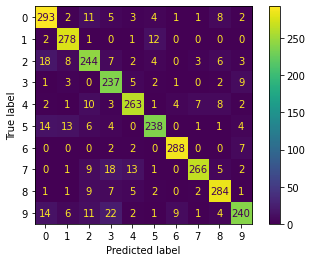

In [7]:
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train, y_train)
knn_prediction = knn_model.predict(X_test)
knn_acc = accuracy_score(y_test, knn_prediction)
print("Accuracy: " + str(knn_acc))
cm = confusion_matrix(y_test, knn_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_model.classes_)
disp.plot()

## 3.2 - SVM 

Accuracy: 0.8324991658324992


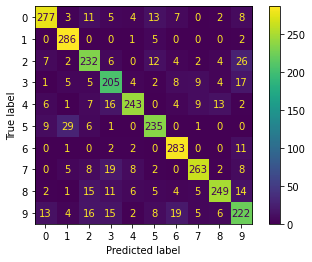

In [28]:
svm_model = SVC()
svm_model.fit(X_train, y_train)
svm_prediction = svm_model.predict(X_test)
svm_acc = accuracy_score(y_test, svm_prediction)
print("Accuracy: " + str(svm_acc))
cm = confusion_matrix(y_test, svm_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_model.classes_)
disp.plot()

## 3.3 - Naive Bayes

Accuracy: 0.5138471805138471


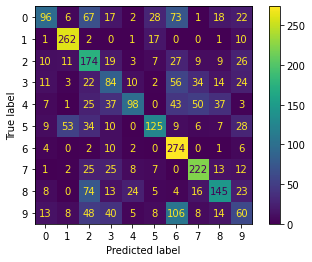

In [10]:
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
nb_prediction = nb_model.predict(X_test)
nb_acc = accuracy_score(y_test, nb_prediction)
print("Accuracy: " + str(nb_acc))
cm = confusion_matrix(y_test, nb_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb_model.classes_)
disp.plot()

## 3.4 - Decision Tree

Accuracy: 0.6426426426426426


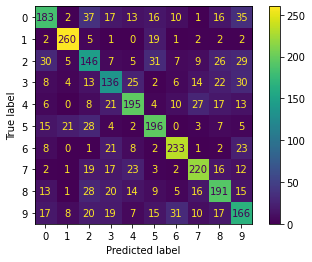

In [11]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
dt_prediction = dt_model.predict(X_test)
dt_acc = accuracy_score(y_test, dt_prediction)
print("Accuracy: " + str(dt_acc))
cm = confusion_matrix(y_test, dt_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt_model.classes_)
disp.plot()

## 3.5 - Random Forest

Accuracy: 0.8625291958625292


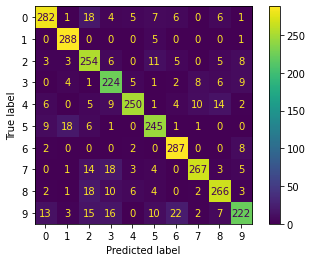

In [12]:
rf_model = RandomForestClassifier(n_estimators=350)
rf_model.fit(X_train, y_train)
rf_prediction = rf_model.predict(X_test)
rf_acc = accuracy_score(y_test, rf_prediction)
print("Accuracy: " + str(rf_acc))
cm = confusion_matrix(y_test, rf_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot()

## 3.6 - Neural Network

In [355]:
str(len(X_train)) + ' ' + str(len(X_test))

'7992 1998'

In [71]:
_X_test, X_val, _y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

In [352]:
# Define model
nn_model = keras.Sequential([
    Dense(512, activation='relu', input_shape=[len(X_train.columns)]),
    Dropout(0.2),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(10, activation='softmax')
])
nn_model.compile(metrics=['accuracy'],
                    loss='sparse_categorical_crossentropy',
                    optimizer='adam')
nn_model.summary()

early_stopping = EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True
)
history = nn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=1000,
    callbacks=[early_stopping])

Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_244 (Dense)            (None, 512)               29696     
_________________________________________________________________
dropout_132 (Dropout)        (None, 512)               0         
_________________________________________________________________
batch_normalization_60 (Batc (None, 512)               2048      
_________________________________________________________________
dense_245 (Dense)            (None, 256)               131328    
_________________________________________________________________
dropout_133 (Dropout)        (None, 256)               0         
_________________________________________________________________
batch_normalization_61 (Batc (None, 256)               1024      
_________________________________________________________________
dense_246 (Dense)            (None, 128)             

Accuracy: 0.913913913913914


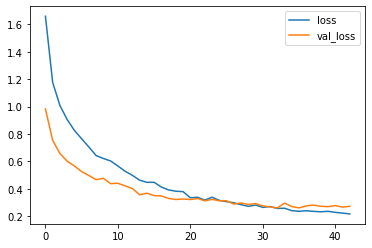

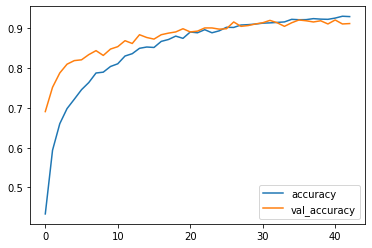

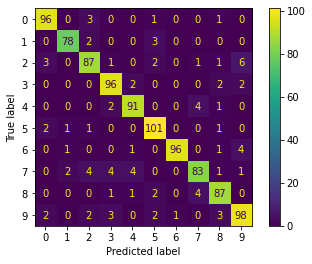

In [353]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();
nn_prediction_distributions = nn_model.predict(_X_test)
nn_prediction = []
for i in range(len(nn_prediction_distributions)):
    nn_prediction.append(np.argmax(nn_prediction_distributions[i]))
    
nn_acc = accuracy_score(_y_test, nn_prediction)
print("Accuracy: " + str(nn_acc))
cm = confusion_matrix(_y_test, nn_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot()

## 3.7 - Convolutional Neural Network (CNN)

In [356]:
# Define model
cnn_X_train = np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1)
cnn_X_test = np.array(_X_test).reshape(_X_test.shape[0], _X_test.shape[1], 1)
cnn_X_val = np.array(X_val).reshape(X_val.shape[0], X_val.shape[1], 1)

cnn_model = keras.Sequential([
    Conv1D(128, 5, activation='relu', padding='same', input_shape=(cnn_X_train.shape[1], 1)),
    BatchNormalization(),
    Conv1D(128, 7, activation='relu', padding='same'),
    BatchNormalization(),
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dense(256, activation='sigmoid'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(128, activation='sigmoid'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(10, activation='softmax')
])
cnn_model.compile(metrics=['accuracy'],
                    loss='sparse_categorical_crossentropy',
                    optimizer='adam')
cnn_model.summary()

early_stopping = EarlyStopping(
    patience=15,
    min_delta=0.0005,
    restore_best_weights=True
)
history = cnn_model.fit(
    cnn_X_train, y_train,
    validation_data=(cnn_X_val, y_val),
    epochs=1000,
    callbacks=[early_stopping])

Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_67 (Conv1D)           (None, 57, 128)           768       
_________________________________________________________________
batch_normalization_64 (Batc (None, 57, 128)           512       
_________________________________________________________________
conv1d_68 (Conv1D)           (None, 57, 128)           114816    
_________________________________________________________________
batch_normalization_65 (Batc (None, 57, 128)           512       
_________________________________________________________________
flatten_34 (Flatten)         (None, 7296)              0         
_________________________________________________________________
dense_249 (Dense)            (None, 256)               1868032   
_________________________________________________________________
batch_normalization_66 (Batc (None, 256)             

Accuracy: 0.8898898898898899


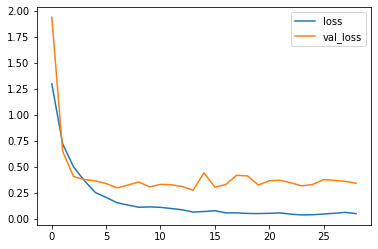

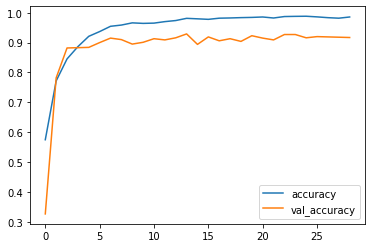

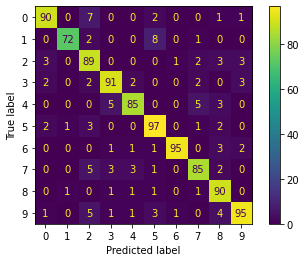

In [358]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();
cnn_prediction_distributions = cnn_model.predict(cnn_X_test)
cnn_prediction = []
for i in range(len(cnn_prediction_distributions)):
    cnn_prediction.append(np.argmax(cnn_prediction_distributions[i]))

cnn_acc = accuracy_score(_y_test, cnn_prediction)
print("Accuracy: " + str(cnn_acc))
cm = confusion_matrix(_y_test, cnn_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot()

## 3.8 - Baseline model evaluation

<AxesSubplot:xlabel='model', ylabel='accuracy'>

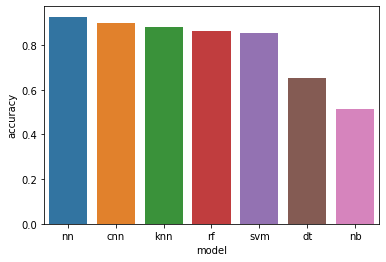

In [350]:
base_model_eval_data = { 'knn': knn_acc, 'svm': svm_acc, 'nb': nb_acc, 'dt': dt_acc,
                        'rf': rf_acc, 'nn': nn_acc, 'cnn': cnn_acc }

list(base_model_eval_data.items())
base_model_eval_df = pd.DataFrame(data=list(base_model_eval_data.items()), columns=['model', 'accuracy'])
base_model_eval_df = base_model_eval_df.sort_values('accuracy', ascending=False).reset_index()
sns.barplot(x='model', y='accuracy', data=base_model_eval_df)

As shown in the graph above, the worst performant models were the Decision Tree and the Naive Bayes, which means that from now on, these will be ignored. The best model was a Neural Network with an aproximate accuracy of 92%.<br/>
On the next section, I'll be fine tuning the parameters of the best models: Neural Network, Convolutional Neural Network, KNN, Random Forest and SVM.

# 4 - Hyper-parameters fine tuning

## 4.1 - SVM tuning

In [13]:
svm_grid_search = {
    'kernel': ['linear', 'poly'], #'rbf', 'sigmoid'],
    'gamma': [10, 100],
    'C': [1, 10, 100],
}
svm_params = []

for k in svm_grid_search['kernel']:
    for g in svm_grid_search['gamma']:
        for c in svm_grid_search['C']:
                print("Kernel: " + k + "  Gamma: " + str(g) + "  C: " + str(c) + "....  ", end = '')
                model = SVC(kernel=k, gamma=g, C=c)
                acc = sum(cross_val_score(model, X_train, y_train, cv=3)) / 3
                svm_params.append([k, g, c, acc])
                print(" Done (" + str(acc) + ")")
            
svm_params_df = pd.DataFrame(data=svm_params, columns=['kernel', 'gamma', 'C', 'accuracy'])
svm_params_df = svm_params_df.sort_values('accuracy', ascending=False)
svm_params_df.head()

Kernel: linear  Gamma: 10  C: 1....   Done (0.7431717431717431)
Kernel: linear  Gamma: 10  C: 10....   Done (0.7377377377377377)
Kernel: linear  Gamma: 10  C: 100....   Done (0.7358787358787359)
Kernel: linear  Gamma: 100  C: 1....   Done (0.7431717431717431)
Kernel: linear  Gamma: 100  C: 10....   Done (0.7377377377377377)
Kernel: linear  Gamma: 100  C: 100....   Done (0.7358787358787359)
Kernel: poly  Gamma: 10  C: 1....   Done (0.8658658658658659)
Kernel: poly  Gamma: 10  C: 10....   Done (0.8658658658658659)
Kernel: poly  Gamma: 10  C: 100....   Done (0.8658658658658659)
Kernel: poly  Gamma: 100  C: 1....   Done (0.8658658658658659)
Kernel: poly  Gamma: 100  C: 10....   Done (0.8658658658658659)
Kernel: poly  Gamma: 100  C: 100....   Done (0.8658658658658659)


,kernel,gamma,C,accuracy
6,poly,10,1,0.865866
7,poly,10,10,0.865866
8,poly,10,100,0.865866
9,poly,100,1,0.865866
10,poly,100,10,0.865866


Accuracy: 0.8902235568902236


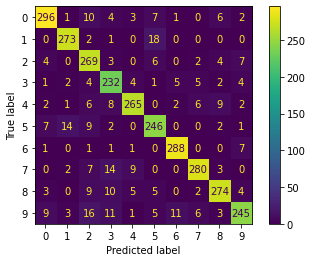

In [39]:
best_svm_params = svm_params_df.iloc[0]
best_svm_model = SVC(kernel=best_svm_params.kernel, C=best_svm_params.C, gamma=best_svm_params.gamma)
best_svm_model.fit(X_train, y_train)
best_svm_pred = best_svm_model.predict(X_test)
best_svm_acc = accuracy_score(y_test, best_svm_pred)
print("Accuracy: " + str(best_svm_acc))

cm = confusion_matrix(y_test, best_svm_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## 4.2 - Random Forest fine tuning

In [51]:
rf_grid_search = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 20, 100],
    'max_features': [None, 'sqrt', 'log2'],
    'min_samples_leaf': [1, 20, 50],
    'n_estimators': [50, 100, 150,]
}

list(rf_grid_search.keys()) + ['accuracy']

['criterion',
 'max_depth',
 'max_features',
 'min_samples_leaf',
 'n_estimators',
 'accuracy']

In [59]:
rf_grid_search = {
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2'],
    'n_estimators': [200, 300, 400, 500, 600]
}
rf_params = []

for c in rf_grid_search['criterion']:
    for mf in rf_grid_search['max_features']:
        for ne in rf_grid_search['n_estimators']:
            print("Crit: " + c + "  MxFeat: " + str(mf) + "  nEst: " + str(ne)  + "....  ", end = '')
            model = RandomForestClassifier(
                criterion=c, max_features=mf, n_estimators=ne,
            )
            acc = sum(cross_val_score(model, X_train, y_train, cv=3)) / 3
            rf_params.append([c, mf, ne, acc])
            print(" Done (" + str(acc) + ")")
                     
rf_params_cols = list(rf_grid_search.keys()) + ['accuracy']
rf_params_df = pd.DataFrame(data=rf_params, columns=rf_params_cols)
rf_params_df = rf_params_df.sort_values('accuracy', ascending=False)
rf_params_df.head()

Crit: gini  MxFeat: sqrt  nEst: 200....   Done (0.833976833976834)
Crit: gini  MxFeat: sqrt  nEst: 300....   Done (0.8374088374088373)
Crit: gini  MxFeat: sqrt  nEst: 400....   Done (0.838981838981839)
Crit: gini  MxFeat: sqrt  nEst: 500....   Done (0.8399828399828401)
Crit: gini  MxFeat: sqrt  nEst: 600....   Done (0.8405548405548405)
Crit: gini  MxFeat: log2  nEst: 200....   Done (0.8296868296868297)
Crit: gini  MxFeat: log2  nEst: 300....   Done (0.8356928356928357)
Crit: gini  MxFeat: log2  nEst: 400....   Done (0.8381238381238382)
Crit: gini  MxFeat: log2  nEst: 500....   Done (0.8335478335478336)
Crit: gini  MxFeat: log2  nEst: 600....   Done (0.8365508365508365)
Crit: entropy  MxFeat: sqrt  nEst: 200....   Done (0.8348348348348349)
Crit: entropy  MxFeat: sqrt  nEst: 300....   Done (0.8391248391248393)
Crit: entropy  MxFeat: sqrt  nEst: 400....   Done (0.8411268411268411)
Crit: entropy  MxFeat: sqrt  nEst: 500....   Done (0.8421278421278421)
Crit: entropy  MxFeat: sqrt  nEst: 600

,criterion,max_features,n_estimators,accuracy
14,entropy,sqrt,600,0.842271
13,entropy,sqrt,500,0.842128
12,entropy,sqrt,400,0.841127
4,gini,sqrt,600,0.840555
3,gini,sqrt,500,0.839983


As seen in the results above, there is still room for improvement relating to the n_estimators parameter. So, I'll run some more tests to see if there are better values for this parameter.

In [62]:
rf_grid_search2 = {
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt'],
    'n_estimators': [700, 750, 800]
}

for c in rf_grid_search2['criterion']:
    for mf in rf_grid_search2['max_features']:
        for ne in rf_grid_search2['n_estimators']:
            print("Crit: " + c + "  MxFeat: " + str(mf) + "  nEst: " + str(ne)  + "....  ", end = '')
            model = RandomForestClassifier(
                criterion=c, max_features=mf, n_estimators=ne,
            )
            acc = sum(cross_val_score(model, X_train, y_train, cv=3)) / 3
            rf_params.append([c, mf, ne, acc])
            print(" Done (" + str(acc) + ")")
                     
rf_params_cols = list(rf_grid_search.keys()) + ['accuracy']
rf_params_df = pd.DataFrame(data=rf_params, columns=rf_params_cols)
rf_params_df = rf_params_df.sort_values('accuracy', ascending=False)
rf_params_df.head()

Crit: gini  MxFeat: sqrt  nEst: 700....   Done (0.8394108394108394)
Crit: gini  MxFeat: sqrt  nEst: 750....   Done (0.8406978406978407)
Crit: gini  MxFeat: sqrt  nEst: 800....   Done (0.8426998426998428)
Crit: entropy  MxFeat: sqrt  nEst: 700....   Done (0.8408408408408409)
Crit: entropy  MxFeat: sqrt  nEst: 750....   Done (0.8405548405548405)
Crit: entropy  MxFeat: sqrt  nEst: 800....   Done (0.8419848419848419)


,criterion,max_features,n_estimators,accuracy
24,gini,sqrt,800,0.842700
14,entropy,sqrt,600,0.842271
13,entropy,sqrt,500,0.842128
27,entropy,sqrt,800,0.841985
20,gini,sqrt,700,0.841127


Accuracy: 0.8708708708708709


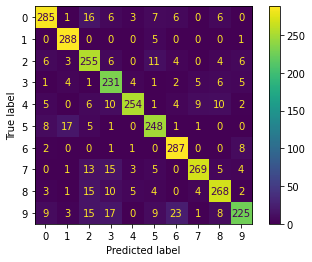

In [68]:
best_rf_params = rf_params_df.iloc[1]
best_rf_model = RandomForestClassifier(
                criterion=best_rf_params.criterion,
                max_features=best_rf_params.max_features,
                n_estimators=best_rf_params.n_estimators
            )
best_rf_model.fit(X_train, y_train)
best_rf_pred = best_rf_model.predict(X_test)
best_rf_acc = accuracy_score(y_test, best_rf_pred)
print("Accuracy: " + str(best_rf_acc))

cm = confusion_matrix(y_test, best_rf_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## 4.3 - KNN fine tuning

In [43]:
knn_grid_search = {
    'n_neighbors': [2, 3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    #'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2, 3],
}
knn_params = []

for nn in knn_grid_search['n_neighbors']:
    for w in knn_grid_search['weights']:
        #for a in knn_grid_search['algorithm']:
        for p in knn_grid_search['p']:
            print("NN: " + str(nn) + "  W: " + w + "  P: " + str(p) + "....  ", end = '')
            model = KNeighborsClassifier(n_neighbors=nn, weights=w, p=p)
            acc = sum(cross_val_score(model, X_train, y_train, cv=3)) / 3
            knn_params.append([nn, w, p, acc])
            print(" Done (" + str(acc) + ")")
            
knn_params_df = pd.DataFrame(data=knn_params, columns=['n_neighbors', 'weights', 'p', 'accuracy'])
knn_params_df = knn_params_df.sort_values('accuracy', ascending=False)
knn_params_df.head()

NN: 2  W: uniform  P: 1....   Done (0.8687258687258687)
NN: 2  W: uniform  P: 2....   Done (0.8429858429858429)
NN: 2  W: uniform  P: 3....   Done (0.7986557986557986)
NN: 2  W: distance  P: 1....   Done (0.9013299013299013)
NN: 2  W: distance  P: 2....   Done (0.8751608751608752)
NN: 2  W: distance  P: 3....   Done (0.8358358358358359)
NN: 3  W: uniform  P: 1....   Done (0.8774488774488775)
NN: 3  W: uniform  P: 2....   Done (0.8488488488488488)
NN: 3  W: uniform  P: 3....   Done (0.8105248105248105)
NN: 3  W: distance  P: 1....   Done (0.8906048906048906)
NN: 3  W: distance  P: 2....   Done (0.8627198627198628)
NN: 3  W: distance  P: 3....   Done (0.8273988273988273)
NN: 5  W: uniform  P: 1....   Done (0.8571428571428571)
NN: 5  W: uniform  P: 2....   Done (0.8361218361218361)
NN: 5  W: uniform  P: 3....   Done (0.7967967967967967)
NN: 5  W: distance  P: 1....   Done (0.8781638781638782)
NN: 5  W: distance  P: 2....   Done (0.859144859144859)
NN: 5  W: distance  P: 3....   Done (0.82

,n_neighbors,weights,p,accuracy
3,2,distance,1,0.901330
9,3,distance,1,0.890605
15,5,distance,1,0.878164
6,3,uniform,1,0.877449
4,2,distance,2,0.875161


Accuracy: 0.923923923923924


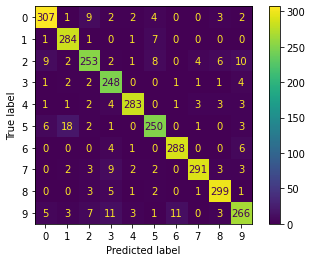

In [49]:
best_knn_params = knn_params_df.iloc[0]
best_knn_model = KNeighborsClassifier(n_neighbors=best_knn_params.n_neighbors,
                                      weights=best_knn_params.weights,
                                      p=best_knn_params.p)
best_knn_model.fit(X_train, y_train)
best_knn_pred = best_knn_model.predict(X_test)
best_knn_acc = accuracy_score(y_test, best_knn_pred)
print("Accuracy: " + str(best_knn_acc))

cm = confusion_matrix(y_test, best_knn_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## 4.4 - Neural Network fine tuning

In [69]:
nn_best_params = []

In [98]:
# Define model
nn_model = keras.Sequential([
    Dense(512, activation='relu', input_shape=[len(X_train.columns)]),
    Dropout(0.2),
    BatchNormalization(),
    Dense(600, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(10, activation='softmax')
])
nn_model.compile(metrics=['accuracy'],
                    loss='sparse_categorical_crossentropy',
                    optimizer=keras.optimizers.RMSprop(learning_rate=0.001))
nn_model.summary()

early_stopping = EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True
)
history = nn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=1000,
    callbacks=[early_stopping])

nn_prediction_distributions = nn_model.predict(_X_test)
nn_prediction = []
for i in range(len(nn_prediction_distributions)):
    nn_prediction.append(np.argmax(nn_prediction_distributions[i]))
    
nn_acc = accuracy_score(_y_test, nn_prediction)
print("Accuracy: " + str(nn_acc))
#nn_best_params.append(['ftrl', nn_acc])

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_111 (Dense)            (None, 512)               29696     
_________________________________________________________________
dropout_90 (Dropout)         (None, 512)               0         
_________________________________________________________________
batch_normalization_90 (Batc (None, 512)               2048      
_________________________________________________________________
dense_112 (Dense)            (None, 600)               307800    
_________________________________________________________________
dropout_91 (Dropout)         (None, 600)               0         
_________________________________________________________________
batch_normalization_91 (Batc (None, 600)               2400      
_________________________________________________________________
dense_113 (Dense)            (None, 256)             

219/219 [==============================] - 1s 6ms/step - loss: 0.2256 - accuracy: 0.9334 - val_loss: 0.2789 - val_accuracy: 0.9173
Epoch 41/1000
219/219 [==============================] - 1s 6ms/step - loss: 0.2245 - accuracy: 0.9309 - val_loss: 0.2931 - val_accuracy: 0.9159
Epoch 42/1000
219/219 [==============================] - 1s 7ms/step - loss: 0.2308 - accuracy: 0.9289 - val_loss: 0.2959 - val_accuracy: 0.9099
Epoch 43/1000
219/219 [==============================] - 1s 6ms/step - loss: 0.2073 - accuracy: 0.9369 - val_loss: 0.2953 - val_accuracy: 0.9139
Epoch 44/1000
219/219 [==============================] - 1s 7ms/step - loss: 0.1983 - accuracy: 0.9401 - val_loss: 0.2784 - val_accuracy: 0.9159
Epoch 45/1000
219/219 [==============================] - 1s 6ms/step - loss: 0.2016 - accuracy: 0.9414 - val_loss: 0.3092 - val_accuracy: 0.9099
Epoch 46/1000
219/219 [==============================] - 1s 6ms/step - loss: 0.2129 - accuracy: 0.9356 - val_loss: 0.2749 - val_accuracy: 0.9166

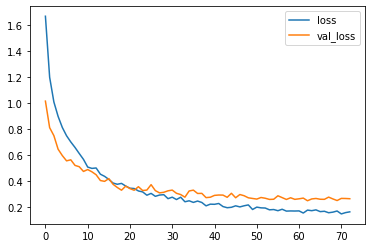

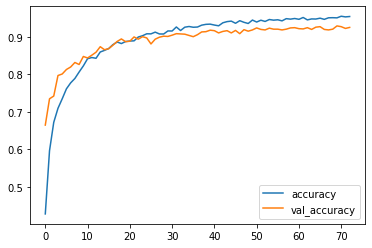

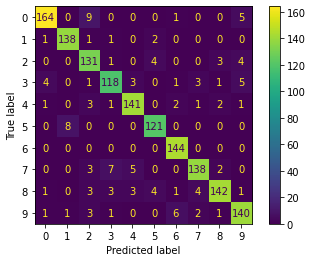

In [99]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();
nn_prediction_distributions = nn_model.predict(_X_test)
nn_prediction = []
for i in range(len(nn_prediction_distributions)):
    nn_prediction.append(np.argmax(nn_prediction_distributions[i]))
    
cm = confusion_matrix(_y_test, nn_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot()

In [86]:
nn_best_params_df = pd.DataFrame(data=nn_best_params, columns=['optimizer', 'accuracy'])
nn_best_params_df

,optimizer,accuracy
0,adam,0.899866
1,sgd,0.898531
2,adamax,0.907877
3,rmsprop,0.911215
4,nadam,0.909212
5,ftrl,0.090788


As shown in the table above, the best optimizer seems to be the 'rmsprop'.

## 4.5 - Convolutional Neural Network (CNN) fine tuning

In [102]:
# Define model
cnn_X_train = np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1)
cnn_X_test = np.array(_X_test).reshape(_X_test.shape[0], _X_test.shape[1], 1)
cnn_X_val = np.array(X_val).reshape(X_val.shape[0], X_val.shape[1], 1)

cnn_model = keras.Sequential([
    Conv1D(128, 5, activation='relu', padding='same', input_shape=(cnn_X_train.shape[1], 1)),
    Conv1D(128, 3, activation='relu'),
    Conv1D(128, 3, activation='relu'),
    BatchNormalization(),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(10, activation='softmax')
])
cnn_model.compile(metrics=['accuracy'],
                    loss='sparse_categorical_crossentropy',
                    optimizer='rmsprop')
cnn_model.summary()

early_stopping = EarlyStopping(
    patience=15,
    min_delta=0.0005,
    restore_best_weights=True
)
history = cnn_model.fit(
    cnn_X_train, y_train,
    validation_data=(cnn_X_val, y_val),
    epochs=1000,
    callbacks=[early_stopping])

cnn_prediction_distributions = cnn_model.predict(cnn_X_test)
cnn_prediction = []
for i in range(len(cnn_prediction_distributions)):
    cnn_prediction.append(np.argmax(cnn_prediction_distributions[i]))

cnn_acc = accuracy_score(_y_test, cnn_prediction)
print("Accuracy: " + str(cnn_acc))

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 57, 128)           768       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 55, 128)           49280     
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 53, 128)           49280     
_________________________________________________________________
batch_normalization_104 (Bat (None, 53, 128)           512       
_________________________________________________________________
flatten_2 (Flatten)          (None, 6784)              0         
_________________________________________________________________
dense_125 (Dense)            (None, 256)               1736960   
_________________________________________________________________
dropout_101 (Dropout)        (None, 256)             

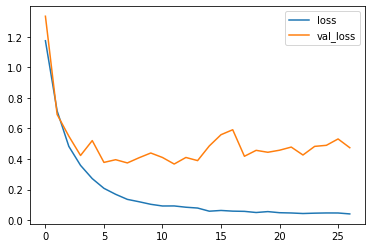

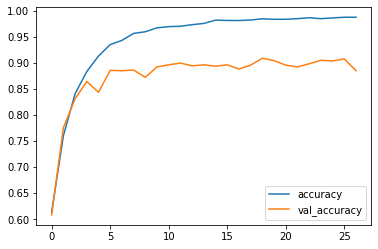

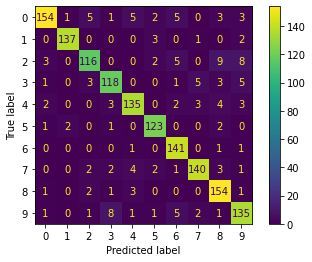

In [103]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

cm = confusion_matrix(_y_test, cnn_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot()

Even though the final accuracy isn't bad, this model tends to overfit, which doesn't happen with the previous model (Neural Network)

## 4.6 - Model's fine tuning evaluation

  model  accuracy
0   knn  0.923924
1    nn  0.919226
2   cnn  0.903204
3   svm  0.890224
4    rf  0.870871


<AxesSubplot:xlabel='model', ylabel='accuracy'>

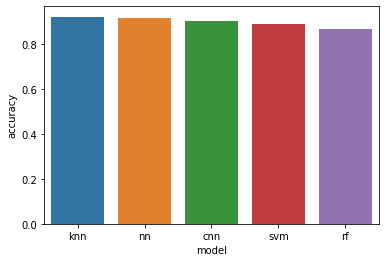

In [108]:
ft_model_eval_data = { 'knn': best_knn_acc, 'svm': best_svm_acc,
                        'rf': best_rf_acc, 'nn': nn_acc, 'cnn': cnn_acc }

ft_model_eval_df = pd.DataFrame(data=list(ft_model_eval_data.items()), columns=['model', 'accuracy'])
ft_model_eval_df = ft_model_eval_df.sort_values('accuracy', ascending=False).reset_index()
print(ft_model_eval_df[['model', 'accuracy']])
sns.barplot(x='model', y='accuracy', data=ft_model_eval_df)

After tuning the different models carefully, we can conclude that the best models were the KNN and the Neural Network. Even though the CNN had 90% accuracy for the test set, it tends to overfit a lot, which is a problem. The SVM also appeared promising, but it didn't perform as well as the KNN and the NN. Finally, the Random Forest ensemble turned to be the worst model. We can hypothesise that this problem can't be efficiently solved by resorting "simple logic" based models.